# Nowcasting
We formulate nowcasting of the Covid-19 epidemic curve (by estimated date of disease onset) as a standard time series regression task with exogeneous information. This task can then be tackled using standard regression models adapted to time series prediction (mostly a curve-fitting exercise with additional information). We implement and test different statistical methods for quantile regression to obtain prediction intervals which quantify the related uncertainty. We experiment with exponential smoothing as a normalization technique.

## Imports

In [1]:
import pandas as pd
import numpy as np

import warnings

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [3]:
# Plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

Import customized regressors which allow joint quantile prediction

In [4]:
# Import own code from other directory
import sys
sys.path.append("../../code/quantile regression")

from GradientBoosting import GradientBoostingQuantileRegressor, LightGBMQuantileRegressor, CatBoostQuantileRegressor
from Linear import LinearQuantileRegressor

Import scoring functionality

In [5]:
# Import own code from other directory
import sys
sys.path.append("../../code/evaluation")

from scoring import outside_interval, interval_score, weighted_interval_score, weighted_interval_score_fast, interval_consistency_score, mape_score, confidence_to_predictive

Sklearn imports

In [6]:
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import HuberRegressor, Lasso, LassoCV

from sklearn.model_selection import LeaveOneOut, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.metrics import make_scorer

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [7]:
from sklearn.utils import indexable, check_random_state
from sklearn.utils.validation import _num_samples

## Data Loading and Preparation

In [8]:
delay = pd.read_pickle("../../data/processed/delay_2020-05-06_imputation_01.pl")

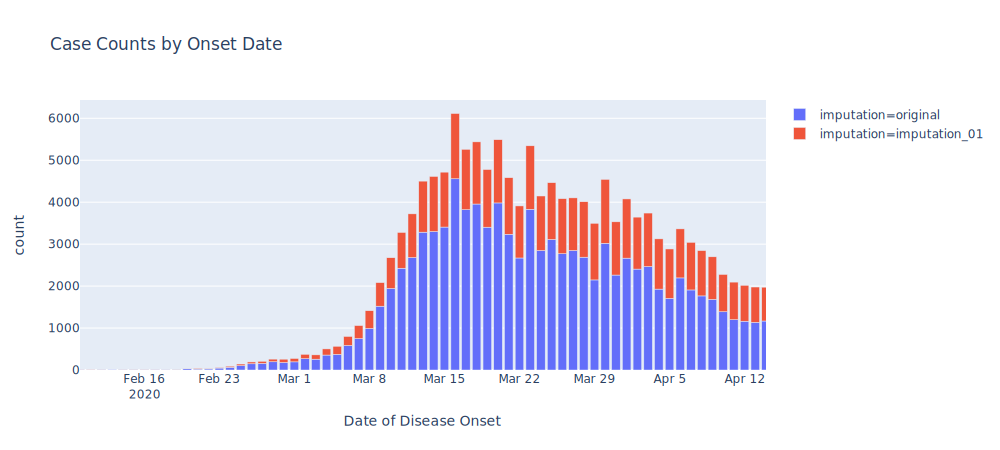

In [9]:
onset = delay.groupby(["date_onset","imputation"]).size().reset_index().rename(columns={0:"count"})
onset = onset.query("imputation=='original' | imputation=='imputation_01'").sort_values("imputation",ascending=False)
px.bar(onset, x='date_onset', y='count', title="Case Counts by Onset Date",labels={"date_onset":"Date of Disease Onset"},color="imputation",range_x=["2020-02-10","2020-04-14"]).show(width=1000)

In [10]:
start_day = "2020-02-01"
cut_off = 30

Remove observations which are too recent to be used as ground truth and clip reporting delay

In [11]:
delay = delay[delay["date_onset"]<(delay["date_onset"].max()-pd.Timedelta(cut_off,"days"))]
delay.loc[delay["reporting_delay_rki"]>cut_off,"reporting_delay_rki"]=cut_off
delay.loc[delay["reporting_delay_rki"]<0,"reporting_delay_rki"]=0

## Reformulate nowcasting as time series prediction task

In [12]:
nowcast_all = delay.groupby(["date_onset","reporting_delay_rki"]).size() #"day_onset","week_onset","weekday_onset",

In [13]:
nowcast_all

date_onset  reporting_delay_rki
2019-12-25  9.0                    1
2019-12-26  30.0                   1
2020-01-01  30.0                   2
2020-01-06  30.0                   1
2020-01-17  30.0                   2
                                  ..
2020-04-04  26.0                   4
            27.0                   1
            28.0                   2
            29.0                   1
            30.0                   5
Length: 1337, dtype: int64

Compute cumulated cases

In [14]:
multi_index = pd.MultiIndex.from_product([pd.date_range(start_day,nowcast_all.index.get_level_values(0).max()),
        list(np.arange(cut_off+1))], names=['date_onset', 'reporting_delay_rki'])

nowcast_all_new = nowcast_all.reindex(multi_index).reset_index()
nowcast_all_new[0]=nowcast_all_new[0].fillna(0)
nowcast_all_new = nowcast_all_new.sort_values(["date_onset","reporting_delay_rki"])
nowcast_all_new["total"] = nowcast_all_new.groupby(["date_onset"])[0].cumsum()
nowcast_all_new = nowcast_all_new.rename(columns={0:"new"})
nowcast_all_new["date_report_rki"]=nowcast_all_new["date_onset"]+pd.to_timedelta(nowcast_all_new["reporting_delay_rki"],"days")

In [15]:
nowcast_all_new.tail(4)

,date_onset,reporting_delay_rki,new,total,date_report_rki
1980,2020-04-04,27,1.0,3118.0,2020-05-01
1981,2020-04-04,28,2.0,3120.0,2020-05-02
1982,2020-04-04,29,1.0,3121.0,2020-05-03
1983,2020-04-04,30,5.0,3126.0,2020-05-04


Compute reporting delay time series

In [16]:
nowcast_ts = nowcast_all_new.pivot(index='date_report_rki', values='total', columns='reporting_delay_rki')
nowcast_ts.columns = [f"N(T-{x},T)" for x in nowcast_ts.columns.get_level_values(0)]
nowcast_ts.index.name = "T"
nowcast_ts.index.freq="d" # set frequency to daily

In [17]:
nowcast_ts.iloc[35:40,]

,"N(T-0,T)","N(T-1,T)","N(T-2,T)","N(T-3,T)","N(T-4,T)","N(T-5,T)","N(T-6,T)","N(T-7,T)","N(T-8,T)","N(T-9,T)","N(T-10,T)","N(T-11,T)","N(T-12,T)","N(T-13,T)","N(T-14,T)","N(T-15,T)","N(T-16,T)","N(T-17,T)","N(T-18,T)","N(T-19,T)","N(T-20,T)","N(T-21,T)","N(T-22,T)","N(T-23,T)","N(T-24,T)","N(T-25,T)","N(T-26,T)","N(T-27,T)","N(T-28,T)","N(T-29,T)","N(T-30,T)"
T,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-07,0.0,4.0,13.0,22.0,35.0,56.0,57.0,52.0,68.0,67.0,68.0,54.0,34.0,25.0,14.0,10.0,10.0,4.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
2020-03-08,0.0,1.0,5.0,17.0,26.0,37.0,60.0,58.0,52.0,68.0,67.0,68.0,54.0,34.0,25.0,14.0,10.0,10.0,4.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0
2020-03-09,4.0,0.0,9.0,19.0,49.0,60.0,67.0,95.0,79.0,84.0,91.0,84.0,82.0,66.0,41.0,26.0,16.0,10.0,12.0,4.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2020-03-10,5.0,16.0,43.0,68.0,61.0,86.0,107.0,102.0,120.0,91.0,98.0,102.0,98.0,93.0,70.0,43.0,31.0,16.0,11.0,13.0,4.0,2.0,5.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0
2020-03-11,5.0,18.0,67.0,148.0,147.0,135.0,146.0,154.0,145.0,160.0,107.0,117.0,119.0,109.0,107.0,79.0,49.0,32.0,17.0,13.0,13.0,4.0,2.0,5.0,4.0,1.0,2.0,0.0,0.0,1.0,8.0


## Exponential Smoothing
We can use simple exponential smoothing as a normalization technique, where the actual time series is divided by the last smoothed level to obtain a normalized series close to 1. This can make differently scaled time series comparable and may increase the potential for cross-learning.

In [18]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#fit1 = Holt(nowcast_ts["final"], damped=True).fit(smoothing_slope=0)
fit1 = ExponentialSmoothing(nowcast_ts["N(T-30,T)"].dropna()).fit(smoothing_level=0.4)

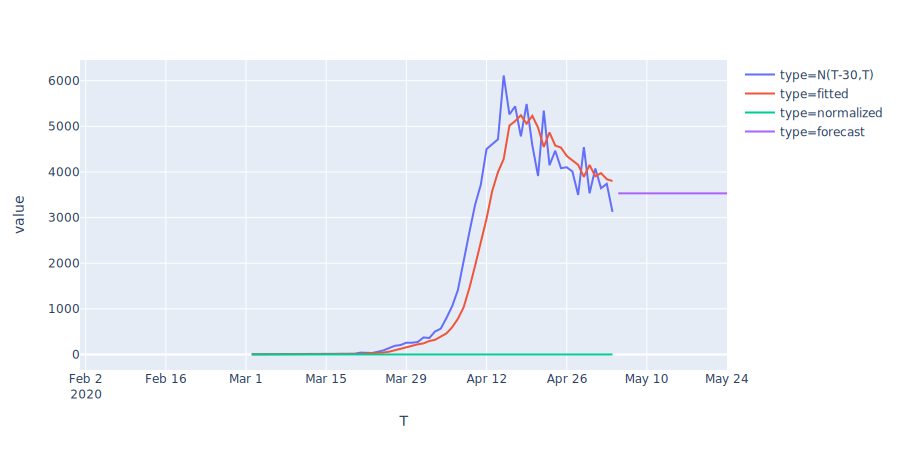

In [19]:
es_result = pd.concat([nowcast_ts["N(T-30,T)"],fit1.fittedvalues,nowcast_ts["N(T-30,T)"]/fit1.level,fit1.forecast(20)],axis=1).rename(columns={"final":"original",0:"fitted",1:"normalized",2:"forecast"}).reset_index().rename(columns={"index":"T"})
#es_result["smoothed"] = es_result["original"]-es_result["fitted"]
es_result = es_result.melt(id_vars="T",var_name="type")
px.line(es_result,x="T",y="value",color="type").show(renderer="svg",width=900)

As can be seen, the fitted level lags behind the epidemic curve and the forecast is constant, both is to be expected by single exponential smoothing without trend (the trend will be estimated by the regression model using the normalized data).

# ml-based Nowcasting

We use the smoothed time series as normalization factor

In [20]:
es_series = [ExponentialSmoothing(nowcast_ts[c].dropna()).fit(smoothing_level=0.2) for c in nowcast_ts.columns]
es_levels = pd.concat([e.level for e in es_series],axis=1,keys=nowcast_ts.columns)

Functionality to formulate nowcasting as a regression task and structure training data accordingly

In [21]:
def normalize_window(ts,levels,kind=None):
    if kind=="multiplicative":
        normalized = pd.DataFrame(ts.to_numpy()/levels.to_numpy(),columns=ts.columns,index=ts.index)
        normalized[ts==0]=0
    elif kind=="additive":
        normalized = pd.DataFrame(ts.to_numpy()-levels.to_numpy(),columns=ts.columns,index=ts.index)
    else:
        normalized = ts
        
    return normalized

def normalize_window_backwards(df,levels,kind=None):
    if kind=="multiplicative":
        renormalized = df.mul(levels,axis="rows")
    elif kind=="additive":
        renormalized = df.add(levels,axis="rows")
    else:
        renormalized = df
        
    return renormalized

def rename_shift(series,shift): 
    return [s.replace("N(T",f"N((T-{shift})").replace(",T)",f",T-{shift})") for s in series]

def get_training_data(cut_off,input_window,exogenous_series,forecast_horizon,norm_kind=None):
    series_names = [f"N(T-{t},T)" for t in range(cut_off,cut_off-exogenous_series-1,-1)]
    ts_list = [nowcast_ts.loc[:,series_names]] + [nowcast_ts.loc[:,series_names].shift(t).rename(columns=dict(zip(series_names,rename_shift(series_names,t)))) for t in range(1,1+input_window)]
    ts_list_normalized = [normalize_window(ts,es_levels.loc[:,series_names],kind=norm_kind) for ts in ts_list]
    training_data = pd.concat(ts_list_normalized,axis=1)
    training_data["target"] = normalize_window(nowcast_ts[[f"N(T-{cut_off},T)"]].shift(-forecast_horizon),es_levels[[f"N(T-{cut_off},T)"]],kind=norm_kind).iloc[:,0]
    training_data = training_data.dropna()
    return training_data

In [22]:
training_data = get_training_data(cut_off=30,input_window=5,exogenous_series=30,forecast_horizon=10,norm_kind=None)
print(training_data.shape)
training_data.head(3)

(29, 187)


,"N(T-30,T)","N(T-29,T)","N(T-28,T)","N(T-27,T)","N(T-26,T)","N(T-25,T)","N(T-24,T)","N(T-23,T)","N(T-22,T)","N(T-21,T)","N(T-20,T)","N(T-19,T)","N(T-18,T)","N(T-17,T)","N(T-16,T)","N(T-15,T)","N(T-14,T)","N(T-13,T)","N(T-12,T)","N(T-11,T)","N(T-10,T)","N(T-9,T)","N(T-8,T)","N(T-7,T)","N(T-6,T)","N(T-5,T)","N(T-4,T)","N(T-3,T)","N(T-2,T)","N(T-1,T)","N(T-0,T)","N((T-1)-30,T-1)","N((T-1)-29,T-1)","N((T-1)-28,T-1)","N((T-1)-27,T-1)","N((T-1)-26,T-1)","N((T-1)-25,T-1)","N((T-1)-24,T-1)","N((T-1)-23,T-1)","N((T-1)-22,T-1)","N((T-1)-21,T-1)","N((T-1)-20,T-1)","N((T-1)-19,T-1)","N((T-1)-18,T-1)","N((T-1)-17,T-1)","N((T-1)-16,T-1)","N((T-1)-15,T-1)","N((T-1)-14,T-1)","N((T-1)-13,T-1)","N((T-1)-12,T-1)",...,"N((T-4)-17,T-4)","N((T-4)-16,T-4)","N((T-4)-15,T-4)","N((T-4)-14,T-4)","N((T-4)-13,T-4)","N((T-4)-12,T-4)","N((T-4)-11,T-4)","N((T-4)-10,T-4)","N((T-4)-9,T-4)","N((T-4)-8,T-4)","N((T-4)-7,T-4)","N((T-4)-6,T-4)","N((T-4)-5,T-4)","N((T-4)-4,T-4)","N((T-4)-3,T-4)","N((T-4)-2,T-4)","N((T-4)-1,T-4)","N((T-4)-0,T-4)","N((T-5)-30,T-5)","N((T-5)-29,T-5)","N((T-5)-28,T-5)","N((T-5)-27,T-5)","N((T-5)-26,T-5)","N((T-5)-25,T-5)","N((T-5)-24,T-5)","N((T-5)-23,T-5)","N((T-5)-22,T-5)","N((T-5)-21,T-5)","N((T-5)-20,T-5)","N((T-5)-19,T-5)","N((T-5)-18,T-5)","N((T-5)-17,T-5)","N((T-5)-16,T-5)","N((T-5)-15,T-5)","N((T-5)-14,T-5)","N((T-5)-13,T-5)","N((T-5)-12,T-5)","N((T-5)-11,T-5)","N((T-5)-10,T-5)","N((T-5)-9,T-5)","N((T-5)-8,T-5)","N((T-5)-7,T-5)","N((T-5)-6,T-5)","N((T-5)-5,T-5)","N((T-5)-4,T-5)","N((T-5)-3,T-5)","N((T-5)-2,T-5)","N((T-5)-1,T-5)","N((T-5)-0,T-5)",target
T,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-07,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,4.0,10.0,10.0,14.0,25.0,34.0,54.0,68.0,67.0,68.0,52.0,57.0,56.0,35.0,22.0,13.0,4.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,4.0,10.0,9.0,14.0,25.0,...,0.0,3.0,3.0,1.0,2.0,8.0,8.0,9.0,15.0,18.0,26.0,26.0,20.0,18.0,12.0,4.0,2.0,0.0,6.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,2.0,7.0,6.0,8.0,14.0,14.0,17.0,16.0,12.0,9.0,8.0,0.0,1.0,13.0
2020-03-08,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,4.0,10.0,10.0,14.0,25.0,34.0,54.0,68.0,67.0,68.0,52.0,58.0,60.0,37.0,26.0,17.0,5.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,4.0,10.0,10.0,14.0,25.0,34.0,...,3.0,4.0,1.0,2.0,9.0,8.0,12.0,18.0,21.0,32.0,35.0,31.0,26.0,22.0,14.0,6.0,1.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,2.0,8.0,8.0,9.0,15.0,18.0,26.0,26.0,20.0,18.0,12.0,4.0,2.0,0.0,13.0
2020-03-09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,4.0,12.0,10.0,16.0,26.0,41.0,66.0,82.0,84.0,91.0,84.0,79.0,95.0,67.0,60.0,49.0,19.0,9.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,4.0,10.0,10.0,14.0,25.0,34.0,54.0,...,4.0,2.0,4.0,10.0,8.0,12.0,23.0,28.0,41.0,51.0,47.0,47.0,39.0,33.0,29.0,8.0,5.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,1.0,2.0,9.0,8.0,12.0,18.0,21.0,32.0,35.0,31.0,26.0,22.0,14.0,6.0,1.0,0.0,10.0


## Walk-Forward Validation

In [23]:
class WalkForwardSplit(TimeSeriesSplit):
    """Customized Time Series cross-validator for scikit-learn api which allows minimum training size parameter."""
    
    def __init__(self, n_splits=5, *, max_train_size=None, min_train_size=1):
        super().__init__(n_splits=n_splits, max_train_size=max_train_size)
        self.min_train_size = min_train_size

    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
            
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        #X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        indices = np.arange(n_samples)
        test_size = (n_samples // n_folds)
        test_starts = range(max(test_size + n_samples % n_folds,self.min_train_size),
                            n_samples, test_size)
        for test_start in test_starts:
            if self.max_train_size and self.max_train_size < test_start:
                yield (indices[test_start - self.max_train_size:test_start],
                       indices[test_start:test_start + test_size])
            else:
                yield (indices[:test_start],
                       indices[test_start:test_start + test_size])

In [24]:
def make_weighted_interval_scorer(quantiles, alphas, weights=None, component="total"):
    if component=="total": comp_i=0
    elif component=="sharpness": comp_i=1
    elif component=="calibration": comp_i=2
    else: raiseValueError("Component must be one out of: total, sharpness or calibration")
    return make_scorer(lambda y_true,y_pred: weighted_interval_score_fast(np.array(y_true),
        alphas=alphas, q_dict=dict(zip(quantiles,y_pred.transpose())), weights=weights, check_consistency=True)[comp_i])

#### Define models for quantile regression

In [25]:
quantiles = [0.05,0.5,0.95]

models = {"gbqr":GradientBoostingQuantileRegressor(quantiles=quantiles,base_params=dict(n_estimators=100)),
          "gbqr_casc":GradientBoostingQuantileRegressor(quantiles=quantiles,base_params=dict(n_estimators=100),cascade=True),
          "lightgbm":LightGBMQuantileRegressor(quantiles=quantiles,base_params=dict(n_estimators=100)),
          "lightgbm_casc":LightGBMQuantileRegressor(quantiles=quantiles,base_params=dict(n_estimators=100),cascade=True),
          "catbqr":CatBoostQuantileRegressor(quantiles=quantiles,base_params=dict(n_estimators=100,silent=True,random_seed=np.random.randint(100))),
          "catbqr_casc":CatBoostQuantileRegressor(quantiles=quantiles,base_params=dict(n_estimators=100,silent=True,random_seed=np.random.randint(100)),cascade=True),
          "lasso+quantreg":Pipeline([
              ('feature_selection', SelectFromModel(Lasso(max_iter=10000),max_features=5,threshold=-np.inf)),
              ('quantile_regression', LinearQuantileRegressor(quantiles=quantiles))])}

#### Define regression task and training data

In [26]:
cut_off=30
input_window = 5
exogenous_series = 30
forecast_horizon = 10

norm_kind=None

training_data = get_training_data(cut_off=cut_off,
                                  input_window=input_window,
                                  exogenous_series=exogenous_series,
                                  forecast_horizon=forecast_horizon,
                                  norm_kind=norm_kind)

X = training_data.drop("target",axis=1)
y = training_data["target"]

min_train_size = 20

#### Define performance scores
Accuracy measures and probabilistic scores (weighted interval score)

In [27]:
alphas = [0.1]
median_index = np.where(np.array(quantiles)==0.5)[0][0]

scoring={
    "absolute_error": make_scorer(lambda y_true,y_pred: (y_true-y_pred[:,median_index]).abs().mean()),
    "percentage_error": make_scorer(lambda y_true,y_pred: (y_true-y_pred[:,median_index]).abs().divide(y_true).mean()),
    "wis_total": make_weighted_interval_scorer(quantiles,alphas=alphas),
    "wis_sharpness": make_weighted_interval_scorer(quantiles,alphas=alphas,component="sharpness"),
    "wis_calibration": make_weighted_interval_scorer(quantiles,alphas=alphas,component="calibration")
}

### Perform walk-forward cross-validation
Evaluate performance on out-of-sample predictions, once without normalization and once with normalization by exponential smoothing.

#### 1) Unnormalized time series

In [28]:
# we set the number of splits to len(y)-1 so that the TimeSeriesSplit-Iterator essentially performs walk-forward cv
cv_specs = dict(
    X=X,
    y=y,
    cv=WalkForwardSplit(n_splits=len(y)-1,max_train_size=None,min_train_size=min_train_size),
)

log = True
df_models=[]

for modelname, model in models.items():
    if log:
        print(f"Validating {modelname}")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        walk_forward_cv = pd.DataFrame(cross_validate(estimator=model,**cv_specs,scoring=scoring))
    walk_forward_cv["T"] = training_data.index[min_train_size:]
    walk_forward_cv["model"] = modelname
    df_models.append(walk_forward_cv)
    
cv_results = pd.concat([pd.DataFrame(m) for m in df_models])

cv_results.groupby("model").mean()

Validating gbqr
Validating gbqr_casc
Validating lightgbm
Validating lightgbm_casc
Validating catbqr
Validating catbqr_casc
Validating lasso+quantreg


,fit_time,score_time,test_absolute_error,test_percentage_error,test_wis_total,test_wis_sharpness,test_wis_calibration
model,,,,,,,
catbqr,0.929010,0.046985,1206.996755,0.415517,11866.807653,720.609592,11146.198061
catbqr_casc,0.985358,0.041998,1145.314340,0.390199,12406.643753,664.091617,11742.552136
gbqr,0.150026,0.003615,857.916808,0.312321,13395.676772,2562.028717,10833.648056
gbqr_casc,0.150684,0.003656,864.455564,0.304218,14316.236379,2513.578211,11802.658168
lasso+quantreg,0.096188,0.004543,262.391120,0.097444,4018.120136,471.707629,3546.412507
lightgbm,0.022159,0.006759,2879.277778,0.907598,13206.680535,2573.566522,10633.114014
lightgbm_casc,0.023271,0.006873,2879.277778,0.907598,13206.680535,2573.566522,10633.114014


Linear quantile regression combined with LASSO-based feature selection clearly performs superior in the unnormalized nowcasting scenario. This should be mainly due to the fact that the gradient boosting methods are based on decision trees which fail to extrapolate the epidemic curve during the first outbreak.

#### 2) Normalized time series

In [34]:
norm_kind="multiplicative"

training_data = get_training_data(cut_off=cut_off,
                                  input_window=input_window,
                                  exogenous_series=exogenous_series,
                                  forecast_horizon=forecast_horizon,
                                  norm_kind=norm_kind)

X = training_data.drop("target",axis=1)
y = training_data["target"]

min_train_size = 20

In [35]:
# we set the number of splits to len(y)-1 so that the TimeSeriesSplit-Iterator essentially performs walk-forward cv
cv_specs = dict(
    X=X,
    y=y,
    cv=WalkForwardSplit(n_splits=len(y)-1,max_train_size=None,min_train_size=min_train_size),
)

log = True
df_models=[]

for modelname, model in models.items():
    if log:
        print(f"Validating {modelname}")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        walk_forward_cv = pd.DataFrame(cross_validate(estimator=model,**cv_specs,scoring=scoring))
    walk_forward_cv["T"] = training_data.index[min_train_size:]
    walk_forward_cv["model"] = modelname
    df_models.append(walk_forward_cv)
    
cv_results = pd.concat([pd.DataFrame(m) for m in df_models])

cv_results.groupby("model").mean()

Validating gbqr
Validating gbqr_casc
Validating lightgbm
Validating lightgbm_casc
Validating catbqr
Validating catbqr_casc
Validating lasso+quantreg


,fit_time,score_time,test_absolute_error,test_percentage_error,test_wis_total,test_wis_sharpness,test_wis_calibration
model,,,,,,,
catbqr,1.031345,0.040778,1.679012,0.112721,5.965092,4.810818,1.154274
catbqr_casc,0.961662,0.039568,1.344592,0.088116,5.484418,4.348544,1.135875
gbqr,0.139961,0.003659,1.086879,0.076502,14.669939,14.669939,0.000000
gbqr_casc,0.147289,0.003656,1.318940,0.090515,17.313190,14.478496,2.834694
lasso+quantreg,0.039841,0.004433,2.576258,0.161462,7.655830,7.381824,0.274006
lightgbm,0.021603,0.006760,2.130795,0.134405,21.274234,21.274234,0.000000
lightgbm_casc,0.024768,0.006873,2.130795,0.134405,21.274234,21.274234,0.000000


In the normalized setting, the clear superior performance of linear quantile regression vanishes and the boosters perform roughly on par. This indicates that normalization using exponential smoothing may really be a way to overcome extrapolation problems with tree-based learners in time series prediction tasks.

## Visualize out-of-sample predictions

In [29]:
model = LightGBMQuantileRegressor(quantiles=[0.05,0.5,0.95])
min_train_size = 10


cut_off=30
input_window = 5
exogenous_series = 30
forecast_horizon = 10

norm_kind="multiplicative"

training_data = get_training_data(cut_off=cut_off,
                                  input_window=input_window,
                                  exogenous_series=exogenous_series,
                                  forecast_horizon=forecast_horizon,
                                  norm_kind=norm_kind)

X = training_data.drop("target",axis=1)
y = training_data["target"]

In [30]:
def walk_forward_predict(estimator,X,y,max_train_size=None,min_train_size=1):
    splitter = WalkForwardSplit(n_splits=len(y)-1,max_train_size=max_train_size,min_train_size=min_train_size)

    X = np.array(X)
    y = np.array(y)
    
    def pred(estimator,train_i,test_i):
        cv_model = clone(estimator)
        cv_model.fit(X[train_i,:],y[train_i])
        return np.hstack((y[test_i].reshape(-1,1),cv_model.predict(X[test_i,:])))
    
    return np.vstack([pred(estimator,train_i,test_i) for train_i, test_i in splitter.split(X,y)])

In [31]:
walk_forward_preds = pd.DataFrame(walk_forward_predict(model,X,y,min_train_size=min_train_size),columns=["truth","lower","median","upper"])
walk_forward_preds["T"] = training_data.index[min_train_size:]

In [32]:
walk_forward_preds_scale = walk_forward_preds.merge(es_levels[f"N(T-{cut_off},T)"].rename("scale").reset_index().shift(1),on="T")
walk_forward_preds_scale.loc[:,["truth","lower","median","upper"]] = normalize_window_backwards(walk_forward_preds_scale[["truth","lower","median","upper"]],walk_forward_preds_scale["scale"],kind=norm_kind)

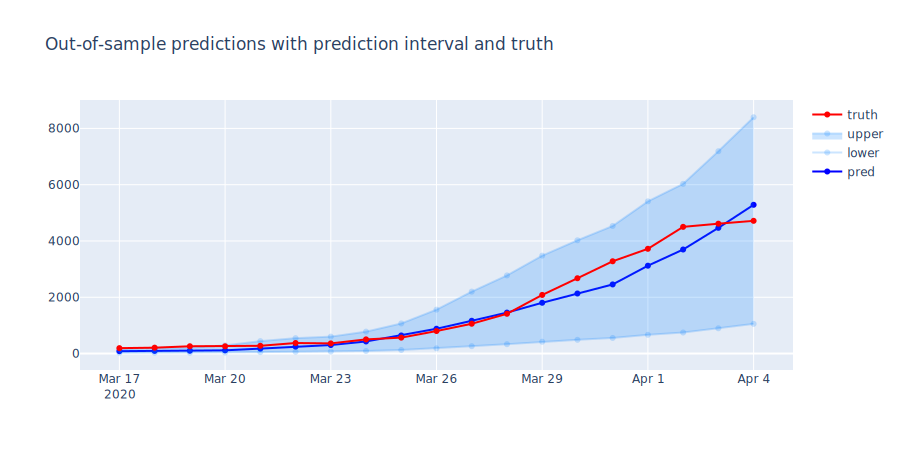

In [33]:
import plotly.graph_objects as go
plot_data = walk_forward_preds_scale[["T","truth","lower","median","upper"]]

fig = go.Figure(
data=[
    go.Scatter(x=plot_data["T"],y=plot_data["median"],name="pred",marker=dict(color="blue")),
    go.Scatter(x=plot_data["T"],y=plot_data["lower"],name="lower",marker=dict(color="rgba(0, 128, 255, 0.2)")),
    go.Scatter(x=plot_data["T"],y=plot_data["upper"],fill="tonexty",name="upper",marker=dict(color="rgba(0, 128, 255, 0.2)"),fillcolor="rgba(0, 128, 255, 0.2)"),
    go.Scatter(x=plot_data["T"],y=plot_data["truth"],name="truth",marker=dict(color="red")),
])
fig.update_layout(title="Out-of-sample predictions with prediction interval and truth")
fig.show(renderer="svg",width=900)

As can be seen, the prediction interval gets wider (in absolute terms) as the epidemic curve progresses. This may be mostly an effect of the multiplicative normalization and renormalization.